In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import conntility
import itertools
from scipy import stats
from connalysis.network import local
from loaders import *
import sys 
sys.path.append('../../library')
from structural_basic import load_connectome

# Load and reformat data 

In [2]:
# Get connectivity object neighborhoods
conn_dir="../../data_analysis/data/"
conn="BBP"
connectome=load_connectome(conn_dir, conn)
nbds=local.neighborhood_indices(connectome.matrix, all_nodes=True)

In [3]:
# Load and format classficiation data 
plot_dict={}
# Get PCA results 
feature="PCA"; plot_dict[feature]={}
root="/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data"
fname_centers_structured=f"{root}/selections_rc_over_nodes.pkl"
fname_centers_random=f"{root}/selections_random_and_random_sparse.pkl"
fname_acc="/gpfs/bbp.cscs.ch/project/proj102/smith/topological_sampling_rel/working_dir/data/classification_results_stacked.pkl"
plot_dict[feature]["structured"], plot_dict[feature]["controls"]=reformat_PCA_results(fname_centers_structured, fname_centers_random, fname_acc, nbds, connectome)

# Get Tridy results  
# For labelling plots, long format of the feature parameters 
fparams_short2long = {
    'asg':'asg', 'asl':'asl', 'asr':'asr',
    'blsg':'blsg', 'blsl':'blsg_low', 'blsr':'blsg_radius',
    'blsgR':'blsg_reversed', 'blsRr':'blsg_reversed_radius', 'blsRl':'blsg_reversed_low',
    'clsg':'clsg', 'clsh':'clsg_high', 'clsr':'clsg_radius',
    'tpsg':'tpsg', 'tpsl':'tpsg_low', 'tpsr':'tpsg_radius',
    'tpsgR':'tpsg_reversed', 'tpsRr':'tpsg_reversed_radius', 'tpsRl':'tpsg_reversed_low',
    'dc2':'dc2', 'dc3':'dc3', 'dc4':'dc4', 'dc5':'dc5', 'dc6':'dc6',
    'nbc':'nbc', 'ec':'ec', 'fcc':'fcc', 'tcc':'tcc',
    'ts':'tribe_size', 'deg':'deg', 'ideg':'in_deg','odeg':'out_deg'
}
# Selection data 
fname='/gpfs/bbp.cscs.ch/project/proj102/lazovski/2022-12-15-ee-subcircuit/parameters/selections-eraf.pkl'
df_centers=load_centers_and_size_union(nbds, fname)
# Accuracy data 
root = '/gpfs/bbp.cscs.ch/project/proj102/lazovski/2024-01-10-rcpn-redo/TriDy-tools/dataframes/'
prefix_structured=root+'eraf-'
prefix_low=root+'era6-'
prefix_high=root+'era7-'
data=load_acc_tridy(prefix_structured, df_centers)
for feature in fparams_short2long.keys():
    plot_dict[feature]={}
    plot_dict[feature]["structured"]=get_plot_df_structured_tridy(df_centers, data[feature])
    

/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/classification/visualization/loaders.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["selection_order"][temp]="bottom"
/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/classification/visualization/loaders.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["selection_order"][temp]="top"


# Plotting

In [4]:
def plot_change_vs_single(ax, df, acc_label, colors, label, marker="o", markersize=5, labelsize=8):
    "Plot change in accuracy vs single selection accuracy"
    base=df[("single",acc_label)]
    y=df[("double",acc_label)]- base
    ax.scatter(base,y, marker=marker, linestyle='',color=colors[label], label=label, s=markersize)
    ax.axline((base.min(),0), slope=0, linestyle="dashed", color="gray")
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_xlabel("Single classification accuracy",fontsize=labelsize)
    ax.set_ylabel("Change in classification accuracy",fontsize=labelsize)
    h, l =ax.get_legend_handles_labels()
    return ax, h, l

def add_shaded_regions(ax, y_bounds_poor, y_bounds_good,
                       x_bounds_poor, x_bounds_redundant, x_bounds_efficient, colors, alpha=0.2):
    # Add shaded regions to distinguish coding regimes                    
    # Poor coding 
    x=x_bounds_poor
    y1=y_bounds_poor[0]*np.ones_like(x)
    y2=y_bounds_poor[1]*np.ones_like(x)
    ax.fill_between(x, y1=y1, y2=y2, alpha=alpha, color=colors["poor_code"], label="poor")

    # Efficient coding 
    x=x_bounds_efficient
    y1=y_bounds_good[0]*np.ones_like(x)
    y2=y_bounds_good[1]*np.ones_like(x)
    ax.fill_between(x, y1=y1, y2=y2, alpha=alpha, color=colors["efficient_code"], label="efficient")

    # Redundant coding 
    x=x_bounds_redundant
    y1=y_bounds_good[0]*np.ones_like(x)
    y2=y_bounds_good[1]*np.ones_like(x)
    ax.fill_between(x, y1=y1, y2=y2, alpha=alpha, color=colors["redundant_code"], label="redundant")
    return ax

def plot_size_vs_acc(ax, df_struct, acc_label, size_label,err_label, 
                     colors, linestyle='', capsize=3, elinewidth=None,
                     labelsize=8, add_legend=True,
                     plot_controls=False, df_random=None,markersize=None,
                     add_shadded_region=True, # parameters of shaded regions
                     largest_efficient=7500, smallest_redundant=15000,
                    min_acc=0.6, max_acc=0.95, min_good_acc=0.8, max_poor_acc=0.7, alpha_regions=0.2):
    # Plot single and double classification 
    for s_type in ["single", "double"]:
        ax.errorbar(df_struct[(s_type, size_label)], df_struct[(s_type, acc_label)],  yerr=df_struct[(s_type, err_label)],
                    linestyle=linestyle, capsize=capsize, elinewidth=elinewidth, label=s_type, color=colors[s_type])
    if add_shadded_region:
        sizes=df_struct[[("single",size_label),("double",size_label)]]
        x_bounds_poor=np.min(sizes), np.max(sizes)
        x_bounds_efficient=np.array([x_bounds_poor[0], largest_efficient])
        x_bounds_redundant=np.array([smallest_redundant, x_bounds_poor[1]])
        y_bounds_poor=[min_acc, max_poor_acc]
        y_bounds_good=[min_good_acc, max_acc]
        ax=add_shaded_regions(ax, y_bounds_poor, y_bounds_good,
                       x_bounds_poor, x_bounds_redundant, x_bounds_efficient, colors, alpha=alpha_regions) 

    if plot_controls: #This only works for PCA at the moment, because I don't know the controls structure of TriDY
        for control_type in ["random_dense", "random_sparse", "random"]:
            df=df_random.xs(control_type, level=0)
            ax.errorbar(df["size"], df["acc"],  yerr=df["sem"],
                        linestyle=linestyle, capsize=capsize,elinewidth=elinewidth, marker="*", markersize=markersize,label=control_type, color=colors[control_type]) 
    ax.set_xlabel("Size of union",fontsize=labelsize)
    ax.set_ylabel("Accuracy",fontsize=labelsize)
    ax.spines[["top", "right"]].set_visible(False)
    if add_legend: ax.legend(frameon=False)
    h, l =ax.get_legend_handles_labels()
    return ax, h, l


In [5]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
marker_size=2
linewidth=1

# Setting up colors 
colors={
    "single": plt.cm.Set3(2), 
    "double": plt.cm.Set3(0),
    "random": plt.cm.Dark2(1),
    "random_dense": "tab:purple",
    "random_sparse": "tab:cyan",
    "poor_code":"C7",
    "redundant_code":"blue", 
    "efficient_code":"red"}
for i, feature in enumerate(fparams_short2long.keys()): # to get any color for all features for general plot
    colors[feature]=f"C{i%10}"
# Hand chosen parameters for selected features 
selected_features=["PCA", "ts", "ec", "blsr"]

# Hand chosen colors for selected features
for i, feature in enumerate(selected_features):
    colors[feature]=plt.cm.Set2(i)

# For better labels
feature_titles={'PCA':'PCA', 
                'ts':'Activity', 
                'ec':'Topology', 
                'blsr':'Spectral'}
# Bounds for coding regime 
acc_lims={
    "PCA":(0.65,0.9),
    "ts":(0.3,0.9), 
    "ec":(0.25,0.9), 
    "blsr":(0.25,0.72)
}
acc_bounds={}
for feature in selected_features:
    length=acc_lims[feature][1]-acc_lims[feature][0]
    acc_bounds[feature]=(acc_lims[feature][1]-length/4,
                         acc_lims[feature][0]+length/3)

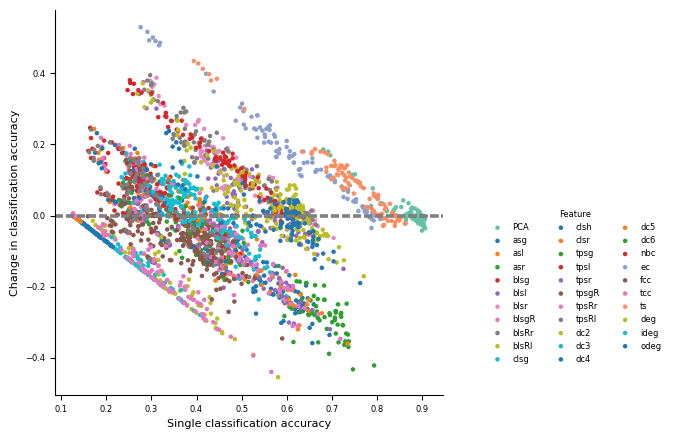

In [6]:
fig, axs = plt.subplots(figsize=(5,5))

# Change in classification 
for feature in ["PCA"]+list(fparams_short2long.keys()):
    acc_label = "acc" if feature=="PCA" else "cv_acc"
    plot_me=plot_dict[feature]["structured"]
    axs, h, l = plot_change_vs_single(axs, plot_me,acc_label, colors, feature, marker="o", markersize=5)
axs.legend(h,l, frameon=False,fontsize=labelsize, ncols=3, bbox_to_anchor=(1.1,0.5), title="Feature", title_fontsize=labelsize)
axs.tick_params(axis="both", labelsize=6)

fig.savefig(f"figs/all_features_change_vs_single_acc.png", transparent=True, bbox_inches="tight")

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2064178/ipykernel_160709/234891101.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


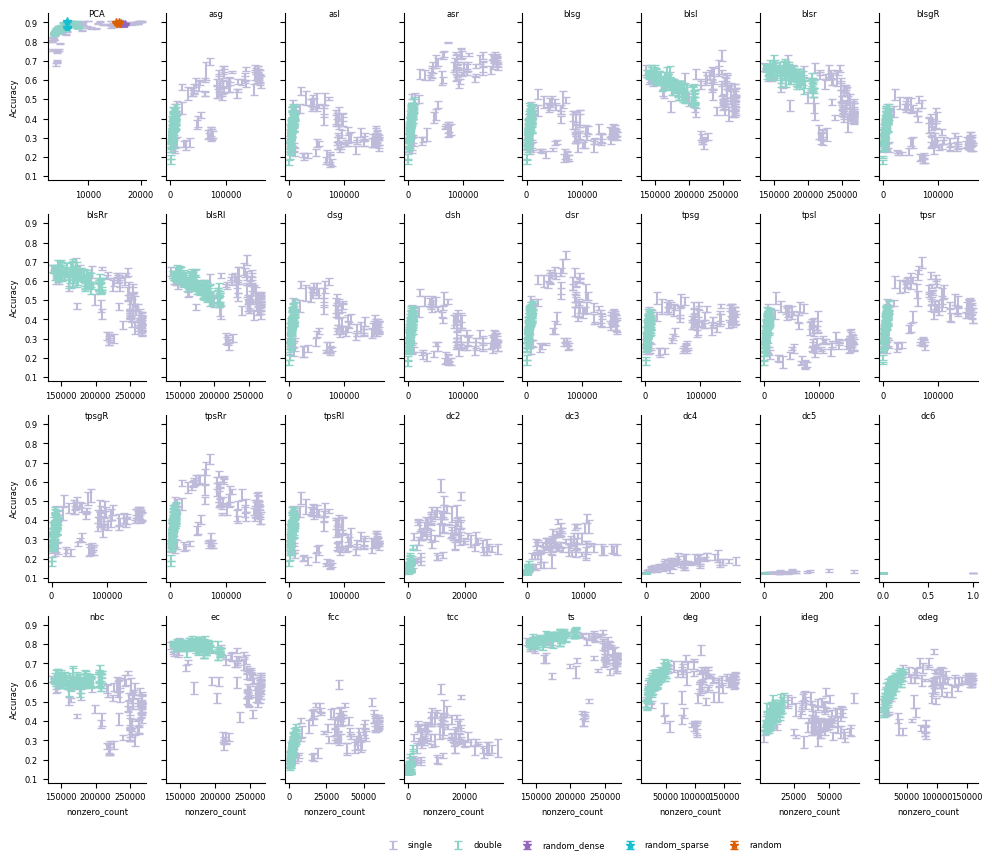

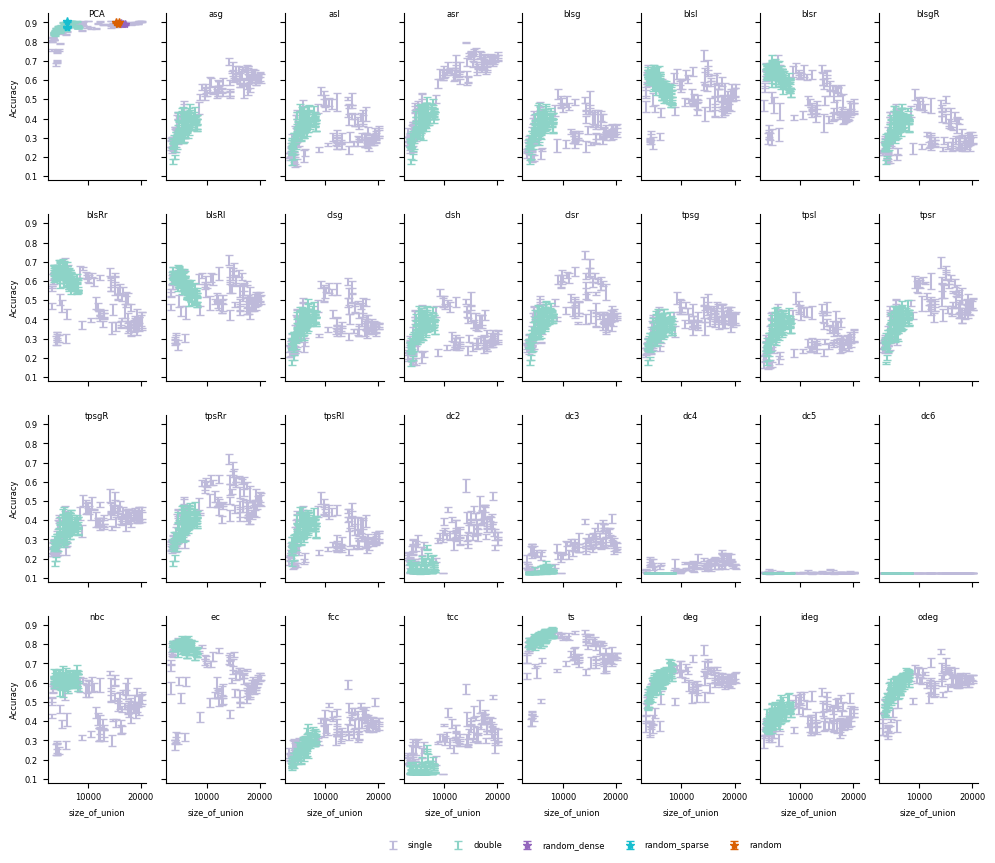

In [7]:
for tridy_size in ["nonzero_count", "size_of_union"]:
    rows=4; cols=8
    sharex=True if tridy_size=="size_of_union" else False
    fig, axs = plt.subplots(rows, cols, figsize=(12,10), sharey=True, sharex=sharex)
    # Classfication vs size 
    selected_features=["PCA"]+list(fparams_short2long.keys())
    for k, feature in enumerate(selected_features):
        i=k//cols; j=k%cols
        plot_me=plot_dict[feature]["structured"]
        acc_label, size_label, err_label = ("acc", "size", "sem") if feature =="PCA" else  ("cv_acc", tridy_size, "cv_err")
        if feature == "PCA":
            plot_me_random=plot_dict[feature]["controls"] # I currently only have controls for the PCA method
            plot_controls=True
        else:
            plot_controls=False
            
        axs[i,j], h, l =plot_size_vs_acc(axs[i,j], plot_me, acc_label, size_label,err_label, 
                                   colors, linestyle='', capsize=3,labelsize=labelsize, add_legend=False, 
                                   plot_controls=plot_controls, df_random=plot_me_random,
                                   add_shadded_region=False)
        axs[i,j].set_title(feature, fontsize=labelsize,y=0.93)
        axs[i,j].set_xlabel("")
        axs[-1,j].set_xlabel(size_label, fontsize=labelsize)
        axs[i,j].set_ylabel("")
        axs[i,0].set_ylabel("Accuracy", fontsize=labelsize)
        if feature =="PCA": #The one that has all labels at the moment 
            axs[-1,5].legend(h,l, ncols=5, frameon=False,fontsize=labelsize,
                            bbox_to_anchor=(1.5,-0.3))

    
    
    for ax in axs.flatten(): 
        ax.tick_params(axis="both", labelsize=ticksize)
    
    
    plt.tight_layout()
    
    fig.savefig(f"figs/all_features_acc_vs_{tridy_size}.png", transparent=True, bbox_inches="tight")

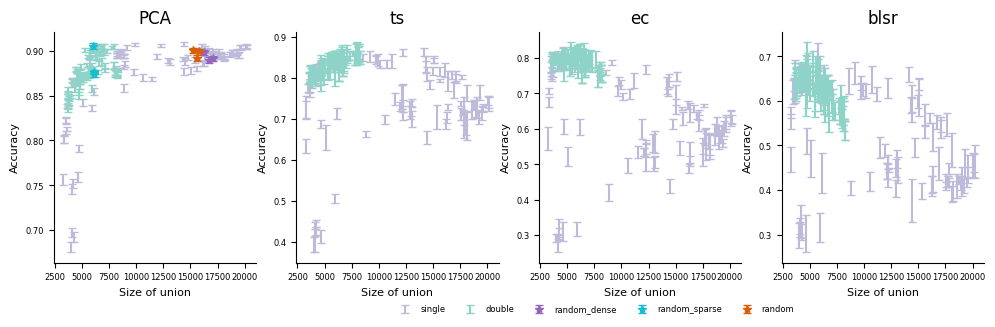

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(12,3), sharey=False)
# Classfication vs size 

selected_features=["PCA", "ts", "ec", "blsr"]
for i, feature in enumerate(selected_features):
    plot_me=plot_dict[feature]["structured"]
    acc_label, size_label, err_label = ("acc", "size", "sem") if feature =="PCA" else  ("cv_acc", "size_of_union", "cv_err")
    if feature == "PCA":
        plot_me_random=plot_dict[feature]["controls"] # I currently only have controls for the PCA method
        plot_controls=True
    else:
        plot_controls=False
        
    axs[i], h, l =plot_size_vs_acc(axs[i], plot_me, acc_label, size_label,err_label, 
                                   colors, linestyle='', capsize=3,
                                   labelsize=8, add_legend=False, 
                                   plot_controls=plot_controls, df_random=plot_me_random,
                                   add_shadded_region=False)
    axs[i].set_title(feature)
    if feature =="PCA":
        axs[2].legend(h,l, bbox_to_anchor=(1.3,-0.15), ncols=5, frameon=False,fontsize=labelsize)




for ax in axs.flatten(): 
    ax.tick_params(axis="both", labelsize=6)

fig.savefig("figs/classification_vs_size_selected_features.png", transparent=True, bbox_inches="tight")

# Main Figure

6


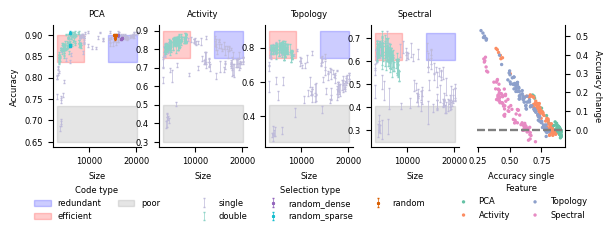

In [9]:
labelsize = 6
width=21*0.8/conversion
rows=1; cols=5

fig, axs =plt.subplots(rows,cols,figsize=(width*1, width*rows*1.2/cols), sharey=False)
# Classfication vs size 
selected_features=["PCA", "ts", "ec", "blsr"]
for i, feature in enumerate(selected_features):
    plot_me=plot_dict[feature]["structured"]
    acc_label, size_label, err_label = ("acc", "size", "sem") if feature =="PCA" else  ("cv_acc", "size_of_union", "cv_err")
    if feature == "PCA":
        plot_me_random=plot_dict[feature]["controls"] # I currently only have controls for the PCA method
        plot_controls=True
    else:
        plot_controls=False
        
    axs[i], h, l =plot_size_vs_acc(axs[i], plot_me, acc_label, size_label,err_label, 
                                   colors, linestyle='', capsize=1,elinewidth=0.5,
                                   labelsize=labelsize, add_legend=False, 
                                   plot_controls=plot_controls, df_random=plot_me_random,markersize=marker_size,
                                   add_shadded_region=True, #parameters of shaded regions
                                   largest_efficient=9000, smallest_redundant=14000,
                                   min_acc=acc_lims[feature][0], max_acc=acc_lims[feature][1],
                                   min_good_acc=acc_bounds[feature][0], max_poor_acc=acc_bounds[feature][1], 
                                   alpha_regions=0.2)
    axs[i].set_title(feature_titles[feature], fontsize=labelsize)
    axs[i].set_xlabel("Size", fontsize=labelsize)

    if feature == "PCA":
        axs[3].legend(h[3:],l[3:], bbox_to_anchor=(0.7,-0.25), ncols=3, frameon=False,
                     title="Selection type",fontsize=labelsize, title_fontsize=labelsize)
        axs[0].legend(h[:3][::-1],l[:3][::-1], bbox_to_anchor=(1.3,-0.25), ncols=2, frameon=False, 
                      title="Code type",fontsize=labelsize, title_fontsize=labelsize)
        axs[0].set_ylabel("Accuracy", fontsize=labelsize)
        print(labelsize)
    else: 
        axs[i].set_ylabel("")
        #axs[i].set_yticks(color="white")


# Change in classification 
for feature in selected_features:
    acc_label = "acc" if feature=="PCA" else "cv_acc"
    plot_me=plot_dict[feature]["structured"]
    axs[4], h, l = plot_change_vs_single(axs[4], plot_me,acc_label, colors, feature, marker="o", markersize=marker_size)
# Flip y-axis to fit in plot 
axs[4].yaxis.tick_right()
axs[4].set_ylabel("Accuracy change", rotation=270, labelpad=10,fontsize=labelsize)
axs[4].set_xlabel("Accuracy single", fontsize=labelsize)
axs[4].yaxis.set_label_position("right")
axs[4].spines[["left"]].set_visible(False)
axs[4].spines[["right"]].set_visible(True)

axs[4].legend(h,[feature_titles[x] for x in l], frameon=False,fontsize=labelsize, ncols=2,
              loc="lower center",bbox_to_anchor=(0.5,-0.65),
              title="Feature", title_fontsize=labelsize)


for ax in axs.flatten(): 
    ax.tick_params(axis="both", labelsize=6)

fig.savefig("figs/classification_summary.png", transparent=True, bbox_inches="tight")
fig.savefig("figs/classification_summary.svg", transparent=True, bbox_inches="tight")